# Benchmarking Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

### 1. Load, Summarize, Insert

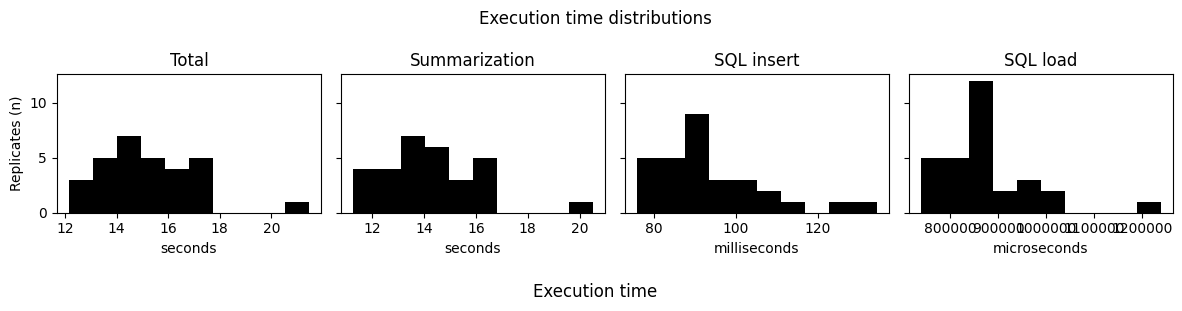

,replicate,num_abstracts,total_replicate_time,total_summarization_time,total_insert_time,total_loading_time,mean_total_time,mean_summarization_time,mean_insert_time,mean_loading_time
0,1,5,81.024608,74.159446,0.672012,6.193149,16.204922,14.831889,0.134402,1.238630
1,2,5,87.608085,82.806621,0.466438,4.335026,17.521617,16.561324,0.093288,0.867005
2,3,5,75.511175,70.447547,0.538895,4.524733,15.102235,14.089509,0.107779,0.904947
3,4,5,63.350354,58.682924,0.402112,4.265318,12.670071,11.736585,0.080422,0.853064
4,5,5,85.457751,80.822233,0.494642,4.140875,17.091550,16.164447,0.098928,0.828175


In [2]:
data = pd.read_csv('../benchmarks/load_summarize_insert/results.csv')

titles = ['Total', 'Summarization', 'SQL insert', 'SQL load']
data_types = ['mean_total_time', 'mean_summarization_time', 'mean_insert_time', 'mean_loading_time']
xlabels = ['seconds', 'seconds', 'milliseconds', 'microseconds']
xaxis_scales = [1, 1, 10**3, 10**6]

fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True, tight_layout=True)

fig.suptitle('Execution time distributions')
fig.supxlabel('Execution time')

axs_num = 0

for title, data_type, xlabel, xaxis_scale in zip(titles, data_types, xlabels, xaxis_scales):

    axs[axs_num].set_title(title)
    axs[axs_num].set_xlabel(xlabel)
    axs[axs_num].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axs[axs_num].hist(
        data[data_type] * xaxis_scale,
        histtype='stepfilled', 
        cumulative=0,
        color='black'
    )

    axs_num += 1

axs[0].set_ylabel('Replicates (n)')

plt.show()

data.head()


### 2. Huggingface Device Map

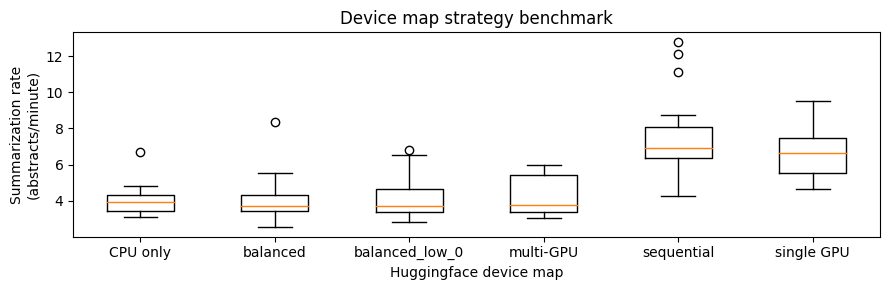

,abstract,device map strategy,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,1,CPU only,19.163196,0.052183,3.131002
1,2,CPU only,15.579454,0.064187,3.851226
2,3,CPU only,15.299519,0.065362,3.921692
3,4,CPU only,19.429485,0.051468,3.088090
4,5,CPU only,15.677886,0.063784,3.827047


In [3]:
data = pd.read_csv('../benchmarks/huggingface_device_map/results.csv')
data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60

wide_data = data.pivot(index='abstract', columns='device map strategy', values='summarization rate (abstracts/min.)')

fig, axs = plt.subplots(1, 1, figsize=(9, 3), tight_layout=True)

axs.set_title('Device map strategy benchmark')
axs.set_xlabel('Huggingface device map')
axs.set_ylabel('Summarization rate\n(abstracts/minute)')
axs.boxplot(wide_data, labels=wide_data.columns)

plt.show()

data.head()

In [4]:
wide_data.head()

device map strategy,CPU only,balanced,balanced_low_0,multi-GPU,sequential,single GPU
abstract,,,,,,
1,3.131002,3.554550,3.673916,3.749652,6.355710,7.918769
2,3.851226,3.264922,3.444995,4.305031,4.261303,7.921348
3,3.921692,4.088814,3.123460,3.698616,11.157204,7.123452
4,3.088090,3.119704,3.308281,3.796763,8.765762,7.285968
5,3.827047,3.647622,4.601863,3.089655,12.817574,4.628868


### 3. Parallel Summarization

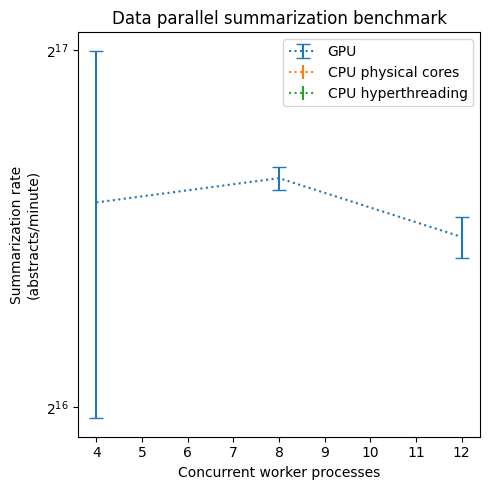

,replicate,abstracts,abstracts per worker,workers,device map strategy,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,0,120,30,4,GPU,0.189973,631.669118,37900.147088
1,1,120,30,4,GPU,0.064821,1851.251770,111075.106205
2,2,120,30,4,GPU,0.062994,1904.928809,114295.728527
3,3,120,30,4,GPU,0.065396,1834.986018,110099.161104
4,4,120,30,4,GPU,0.063064,1902.818711,114169.122645


In [5]:
data = pd.read_csv('../benchmarks/parallel_summarize/results.csv')
data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60

device_map_strategies = ['GPU', 'CPU physical cores', 'CPU hyperthreading']

fig, axs = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

axs.set_title('Data parallel summarization benchmark')
axs.set_xlabel('Concurrent worker processes')
axs.set_ylabel('Summarization rate\n(abstracts/minute)')
axs.set_yscale('log', base=2)
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

for device_map_strategy in device_map_strategies:

    plot_data = data[data['device map strategy'] == device_map_strategy]

    mean = plot_data.groupby(['device map strategy', 'workers']).mean()
    mean.reset_index(inplace=True)
    
    std = plot_data.groupby(['device map strategy', 'workers']).std()
    std.reset_index(inplace=True)

    axs.errorbar(
        mean['workers'], 
        mean['summarization rate (abstracts/min.)'], 
        yerr=std['summarization rate (abstracts/min.)'],
        capsize=5,
        label=device_map_strategy,
        linestyle='dotted'
    )

plt.legend(loc='best')
plt.show()

data.head()

### 4. Model quantization

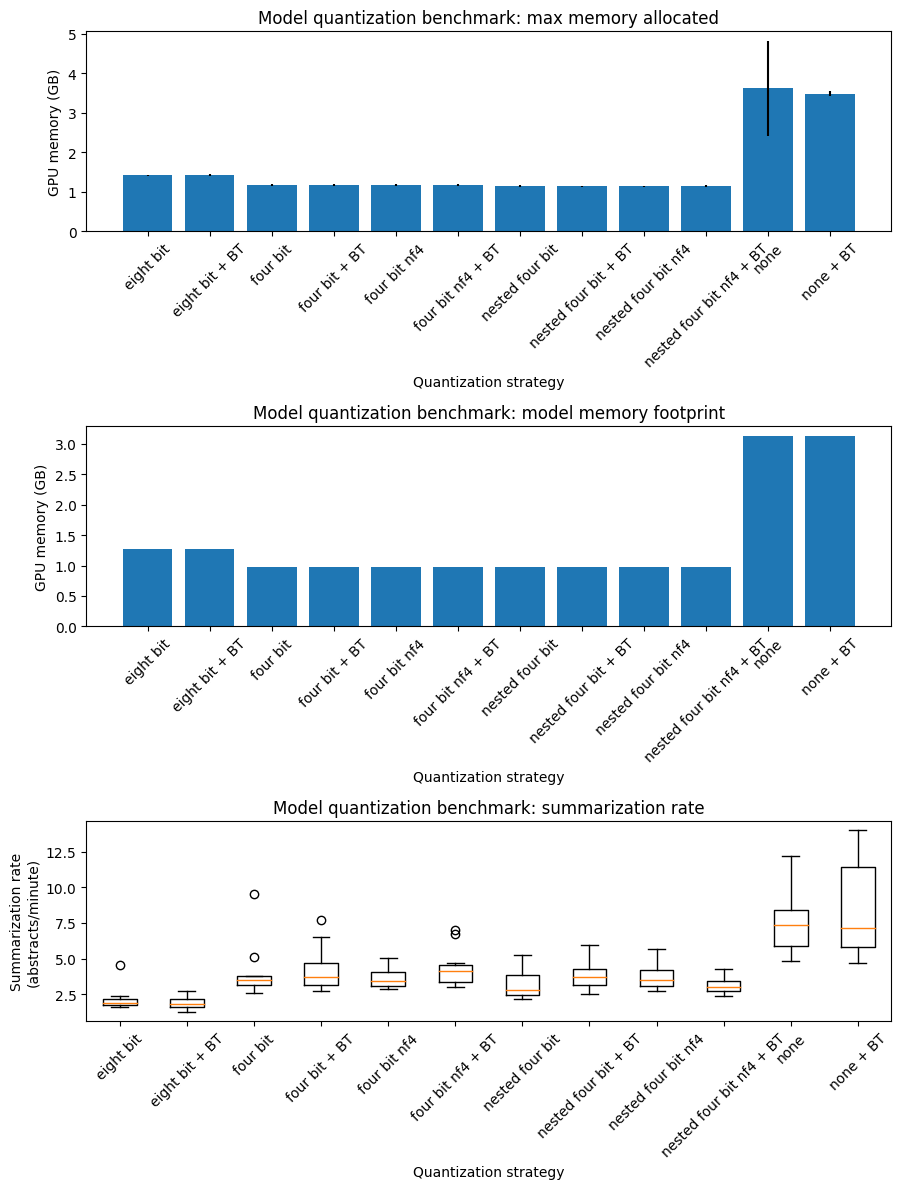

,abstract,quantization strategy,summarization time (sec.),summarization rate (abstracts/sec.),model GPU memory footprint (bytes),max memory allocated (bytes),summarization rate (abstracts/min.),model GPU memory footprint (GB),max memory allocated (GB)
0,1,none,10.884255,0.091876,3132600320,4757159936,5.512550,3.1326,4.757160
1,2,none,7.112705,0.140593,3132600320,3479068672,8.435609,3.1326,3.479069
2,3,none,4.912107,0.203579,3132600320,3463340032,12.214716,3.1326,3.463340
3,4,none,8.217777,0.121687,3132600320,3488113152,7.301244,3.1326,3.488113
4,5,none,8.014868,0.124768,3132600320,3486540288,7.486087,3.1326,3.486540


In [6]:
data = pd.read_csv('../benchmarks/model_quantization/results.csv')
data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60
data['model GPU memory footprint (GB)'] = data['model GPU memory footprint (bytes)'] / 10 ** 9
data['max memory allocated (GB)'] = data['max memory allocated (bytes)'] / 10 ** 9

fig, axs = plt.subplots(3, 1, figsize=(9, 12), tight_layout=True)

mean_max_memory_data = data[['quantization strategy', 'max memory allocated (GB)']].groupby('quantization strategy').mean()
std_max_memory_data = data[['quantization strategy', 'max memory allocated (GB)']].groupby('quantization strategy').std()

axs[0].set_title('Model quantization benchmark: max memory allocated')
axs[0].set_xlabel('Quantization strategy')
axs[0].set_ylabel('GPU memory (GB)')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].bar(
    x=mean_max_memory_data.index, 
    height=mean_max_memory_data['max memory allocated (GB)'],
    yerr=std_max_memory_data['max memory allocated (GB)'] * 3
)

mean_memory_footprint_data = data[['quantization strategy', 'model GPU memory footprint (GB)']].groupby('quantization strategy').mean()

axs[1].set_title('Model quantization benchmark: model memory footprint')
axs[1].set_xlabel('Quantization strategy')
axs[1].set_ylabel('GPU memory (GB)')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].bar(x=mean_memory_footprint_data.index, height=mean_memory_footprint_data['model GPU memory footprint (GB)'])

rate_data = data[['abstract', 'quantization strategy', 'summarization rate (abstracts/min.)']]
rate_data = data.pivot(index='abstract', columns='quantization strategy', values='summarization rate (abstracts/min.)')

axs[2].set_title('Model quantization benchmark: summarization rate')
axs[2].set_xlabel('Quantization strategy')
axs[2].set_ylabel('Summarization rate\n(abstracts/minute)')
axs[2].tick_params(axis='x', labelrotation=45)
axs[2].boxplot(rate_data, labels=rate_data.columns)

plt.show()

data.head()

### 5. Batched summarization, quantized model

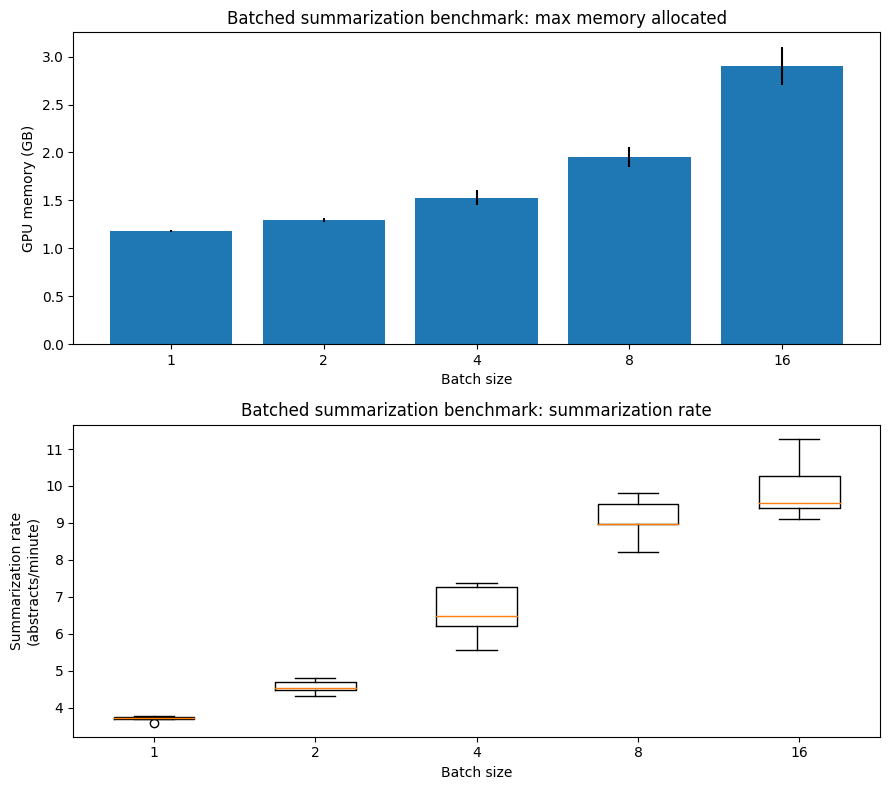

,abstracts,replicate,batch size,summarization time (sec.),summarization rate (abstracts/sec.),model GPU memory footprint (bytes),max memory allocated (bytes),summarization rate (abstracts/min.),max memory allocated (GB)
0,16,0,1,267.130374,0.059896,974903296,1184609280,3.593751,1.184609
1,16,1,1,258.434095,0.061911,974903296,1177530368,3.714680,1.177530
2,16,2,1,259.378468,0.061686,974903296,1180086272,3.701155,1.180086
3,16,3,1,255.177978,0.062701,974903296,1181463040,3.762080,1.181463
4,16,4,1,257.292883,0.062186,974903296,1184019456,3.731156,1.184019


In [9]:
data = pd.read_csv('../benchmarks/batched_inference/results.csv')
data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60
data['max memory allocated (GB)'] = data['max memory allocated (bytes)'] / 10 ** 9

fig, axs = plt.subplots(2, 1, figsize=(9, 8), tight_layout=True)

mean_max_memory_data = data[['batch size', 'max memory allocated (GB)']].groupby('batch size').mean()
std_max_memory_data = data[['batch size', 'max memory allocated (GB)']].groupby('batch size').std()

axs[0].set_title('Batched summarization benchmark: max memory allocated')
axs[0].set_xlabel('Batch size')
axs[0].set_ylabel('GPU memory (GB)')
axs[0].bar(
    x=list(range(len(mean_max_memory_data['max memory allocated (GB)']))), 
    height=mean_max_memory_data['max memory allocated (GB)'],
    yerr=std_max_memory_data['max memory allocated (GB)'] * 3,
    tick_label=mean_max_memory_data.index
)

rate_data = data[['replicate', 'batch size', 'summarization rate (abstracts/min.)']]
rate_data = data.pivot(index='replicate', columns='batch size', values='summarization rate (abstracts/min.)')

axs[1].set_title('Batched summarization benchmark: summarization rate')
axs[1].set_xlabel('Batch size')
axs[1].set_ylabel('Summarization rate\n(abstracts/minute)')
axs[1].boxplot(rate_data, labels=rate_data.columns)

plt.show()

data.head()

### 6. Data parallel, batched summarization, quantized model

In [11]:
data = pd.read_csv('../benchmarks/parallel_batched_summarize/results.csv')
data.head()

,rounds,replicate,batch size,workers,summarization time (sec.),summarization rate (abstracts/sec.)
0,3,0,1,4,80.942879,0.148253
1,3,1,1,4,64.207311,0.186895
2,3,2,1,4,77.794241,0.154253
3,3,3,1,4,72.637769,0.165203
4,3,4,1,4,84.009729,0.142841


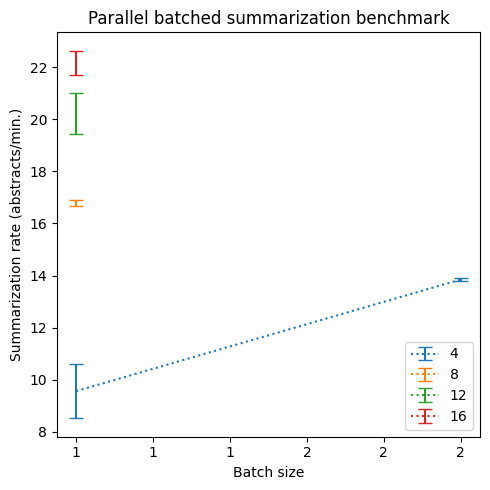

,rounds,replicate,batch size,workers,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,3,0,1,4,80.942879,0.148253,8.895162
1,3,1,1,4,64.207311,0.186895,11.213676
2,3,2,1,4,77.794241,0.154253,9.255184
3,3,3,1,4,72.637769,0.165203,9.912199
4,3,4,1,4,84.009729,0.142841,8.570436


In [13]:
data = pd.read_csv('../benchmarks/parallel_batched_summarize/results.csv')
data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60

worker_nums = data['workers'].unique()

fig, axs = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

axs.set_title('Parallel batched summarization benchmark')
axs.set_xlabel('Batch size')
axs.set_ylabel('Summarization rate (abstracts/min.)')
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

for workers in worker_nums:

    plot_data = data[data['workers'] == workers]

    mean = plot_data.groupby(['batch size']).mean()
    mean.reset_index(inplace=True)
    
    std = plot_data.groupby(['batch size']).std()
    std.reset_index(inplace=True)

    axs.errorbar(
        mean['batch size'], 
        mean['summarization rate (abstracts/min.)'], 
        yerr=std['summarization rate (abstracts/min.)'],
        capsize=5,
        label=workers,
        linestyle='dotted'
    )

plt.legend(loc='lower right')
plt.show()

data.head()

### 6. SQL Insert

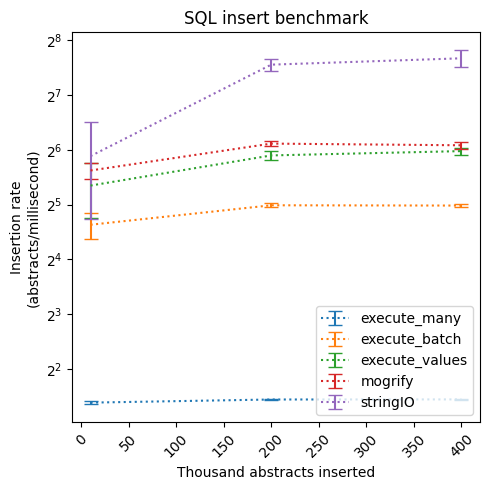

,abstracts,insert time (sec.),insert rate (abstracts/sec.),insert strategy,replicate,insert rate (abstracts/millisecond)
0,10.0,3.772693,2650.626378,execute_many,1,2.650626
1,10.0,3.846135,2600.012807,execute_many,2,2.600013
2,10.0,3.810965,2624.007263,execute_many,3,2.624007
3,10.0,3.817579,2619.461488,execute_many,4,2.619461
4,10.0,3.909431,2557.916853,execute_many,5,2.557917


In [10]:
data = pd.read_csv('../benchmarks/sql_insert/results.csv')
data['insert rate (abstracts/millisecond)'] = data['insert rate (abstracts/sec.)'] / 1000
data['abstracts'] = data['abstracts'] / 1000

insert_strategies = ['execute_many', 'execute_batch', 'execute_values', 'mogrify', 'stringIO']

fig, axs = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

axs.set_title('SQL insert benchmark')
axs.set_xlabel('Thousand abstracts inserted')
axs.set_ylabel('Insertion rate\n(abstracts/millisecond)')
axs.set_yscale('log', base=2)
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axs.tick_params(axis='x', labelrotation=45)

for insert_strategy in insert_strategies:

    plot_data = data[data['insert strategy'] == insert_strategy]

    mean = plot_data.groupby(['insert strategy', 'abstracts']).mean()
    mean.reset_index(inplace=True)
    
    std = plot_data.groupby(['insert strategy', 'abstracts']).std()
    std.reset_index(inplace=True)

    axs.errorbar(
        mean['abstracts'], 
        mean['insert rate (abstracts/millisecond)'], 
        yerr=std['insert rate (abstracts/millisecond)'],
        capsize=5,
        label=insert_strategy,
        linestyle='dotted'
    )

plt.legend(loc='lower right')
plt.show()

data.head()